<a href="https://colab.research.google.com/github/rtajeong/AI_Cluster_APAT/blob/main/1_solar_power_prediction_APAT_rev2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Case study 1: Solar Power Prediction회귀분석 (Regression Nalysis)
- 데이터 분석 기법
- Feature Engineering
- Custom Transformer
- Pipeline()
- 여러 모델의 성능 비교


# Steps
- Step 1: Exploratory Data Analysis (EDA)
  - checking for missing values
  - understanding the distribution of features
  - visualizing relationships between features and the target (SystemProduction).
- Step 2: Regression Models
  - Linear Regression (OLS and SGDRegressor)
- Step 3: Time Series Analysis (skip)
  - ARIMA
  - Prophet
  - LSTM
- Step 4: Machine Learning Algorithms
  - Decision Trees: A simple, yet powerful model for regression tasks.
  - Random Forests: An ensemble method using multiple decision trees.
  - Gradient Boosting Machines: Another ensemble method that builds trees sequentially.
  - Neural Networks: More complex models that can capture intricate patterns in the data (skip)
- data and the original code from: https://www.kaggle.com/code/pythonafroz/27-regression-models-for-solar-power-prediction

## EDA
1. Loading the dataset: The dataset is loaded
using pd.read_csv().
2. Initial Analysis:
  - Missing Values: isnull().sum() is used to check for missing values in the dataset.
  - Summary Statistics: describe() provides a summary of statistics for each feature.
3. Distribution Plots:
  - sns.histplot() is used to plot the distribution of each feature.
4. Pairplot:
  - sns.pairplot() helps visualize the relationships between all features and the target variable, SystemProduction.
5. Correlation Heatmap:
  - sns.heatmap() is used to visualize the correlation between features.

In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from functools import cmp_to_key
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import time

import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [ ]:
df = pd.read_csv('Solar.csv')
pd.concat([df.head(3), df.tail(3)])

,Date-Hour(NMT),WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction
0,01.01.2017-00:00,0.60000000,0,1003.80000000,-7.40000000,0.10000000,97,0.00000000
1,01.01.2017-01:00,1.70000000,0,1003.50000000,-7.40000000,-0.20000000,98,0.00000000
2,01.01.2017-02:00,0.60000000,0,1003.40000000,-6.70000000,-1.20000000,99,0.00000000
8757,31.12.2017-21:00,1.80000000,0,986.70000000,-5.30000000,0.20000000,93,0.00000000
8758,31.12.2017-22:00,2.20000000,0,986.00000000,-5.40000000,0.30000000,92,0.00000000
8759,31.12.2017-23:00,2.40000000,0,985.60000000,-5.90000000,0.40000000,96,0.00000000


In [ ]:
print(df.dtypes)

Date-Hour(NMT)          object
WindSpeed              float64
Sunshine                 int64
AirPressure            float64
Radiation              float64
AirTemperature         float64
RelativeAirHumidity      int64
SystemProduction       float64
dtype: object


- time data conversion to datetime object

In [ ]:
# to convert the string into the datetime object
df['Date-Hour(NMT)'] = pd.to_datetime(df['Date-Hour(NMT)'], format='%d.%m.%Y-%H:%M')
df['Date-Hour(NMT)'][0]

Timestamp('2017-01-01 00:00:00')

- checking missing values

In [ ]:
print(df.isnull().sum())

Date-Hour(NMT)         0
WindSpeed              0
Sunshine               0
AirPressure            0
Radiation              0
AirTemperature         0
RelativeAirHumidity    0
SystemProduction       0
dtype: int64


- view features and target variable over time

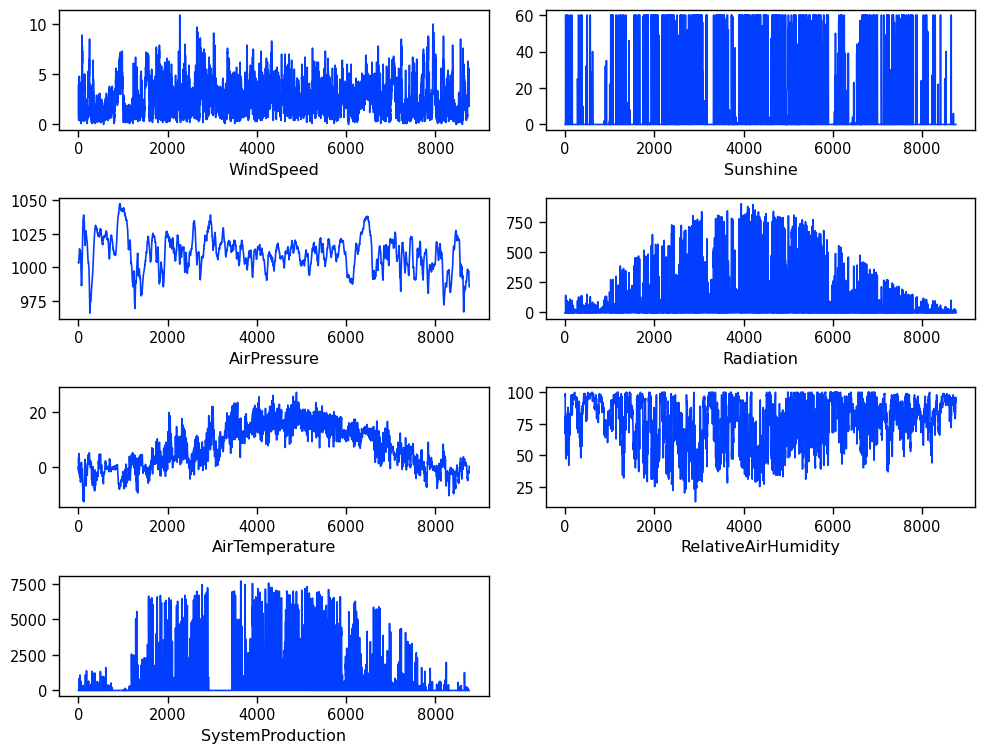

In [ ]:
features = ['WindSpeed', 'Sunshine', 'AirPressure', 'Radiation',
            'AirTemperature', 'RelativeAirHumidity', 'SystemProduction']

plt.figure(figsize=(10, 8))
for i, feature in enumerate(features):
    plt.subplot(4,2,i+1)
    plt.plot(df[feature])
    plt.xlabel(feature)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

<Figure size 800x800 with 0 Axes>

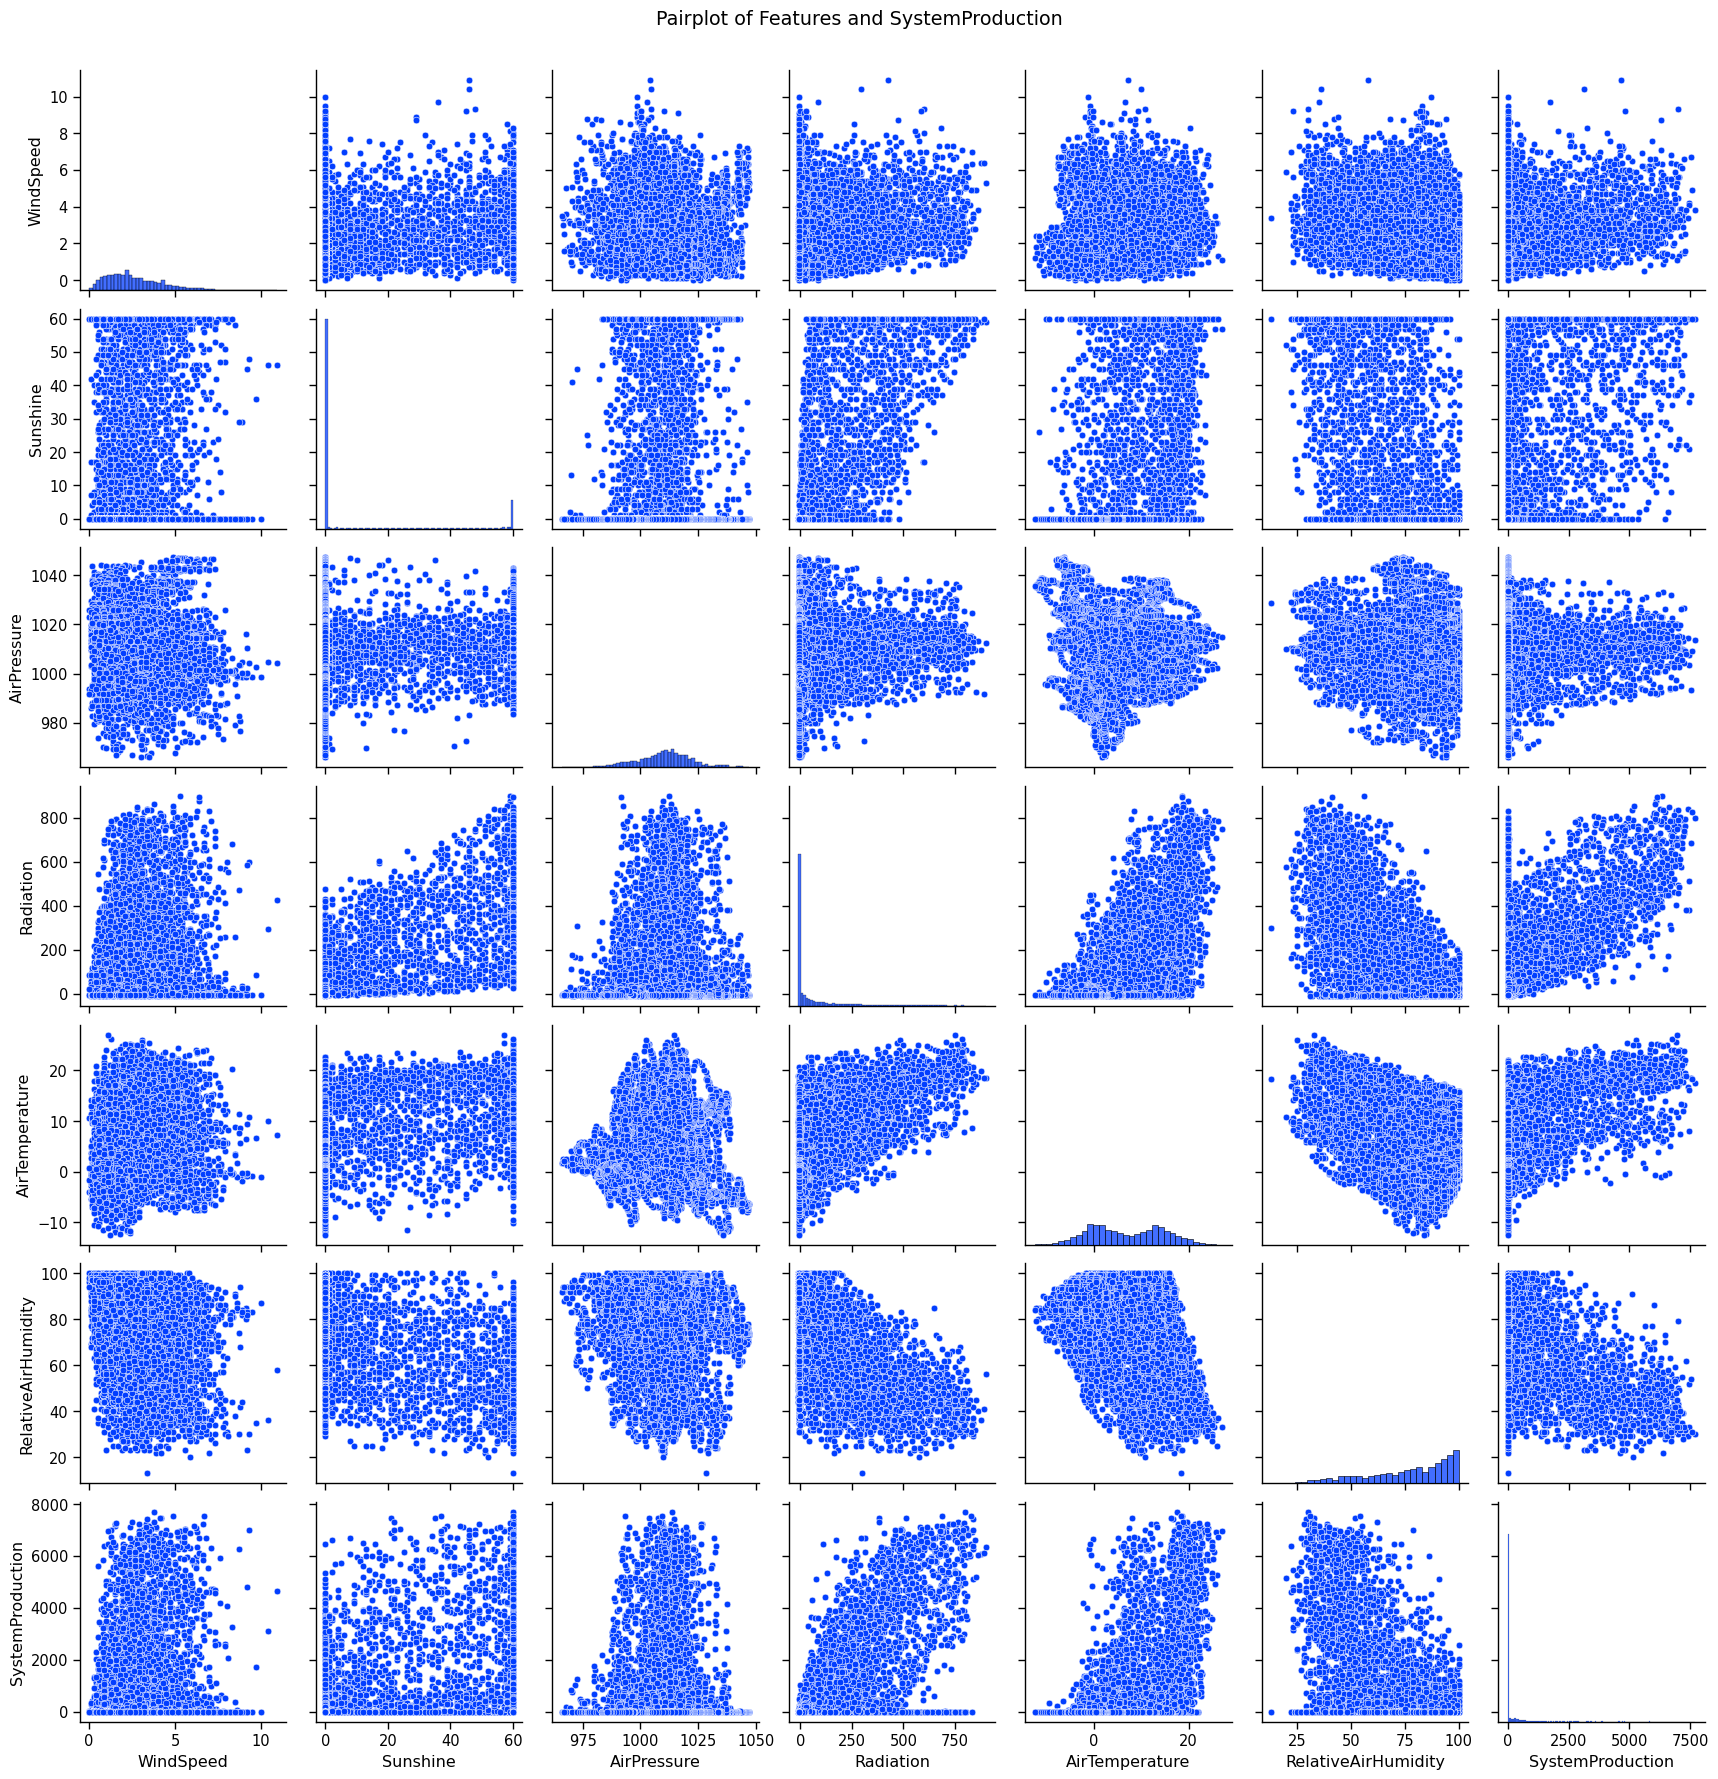

In [ ]:
# Pairplot to visualize relationships between features and SystemProduction
plt.figure(figsize=(8, 8))
sns.pairplot(df[features])
plt.suptitle('Pairplot of Features and SystemProduction', y=1.02)
plt.show()


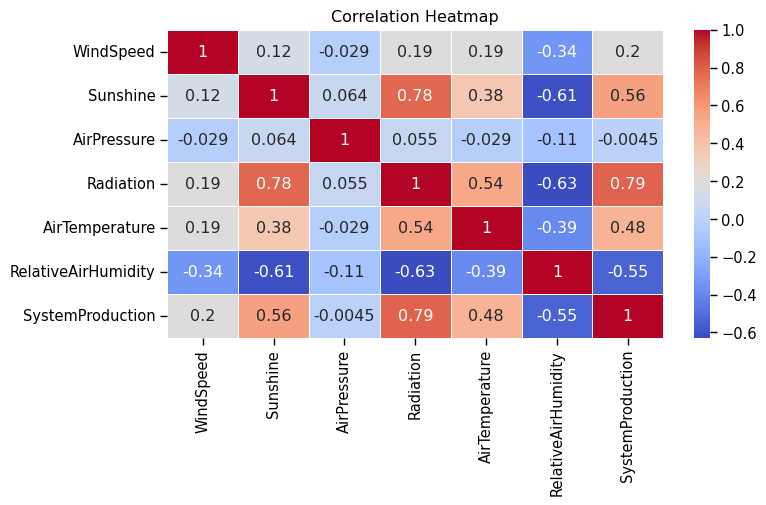

In [ ]:
# Correlation heatmap
plt.figure(figsize=(8, 4))
correlation_matrix = df[features].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

In [ ]:
df.corr()['SystemProduction'].sort_values(ascending=False).to_frame()

,SystemProduction
SystemProduction,1.00000000
Radiation,0.78571664
Sunshine,0.56422757
AirTemperature,0.48040739
WindSpeed,0.19565040
AirPressure,-0.00448716
Date-Hour(NMT),-0.03345414
RelativeAirHumidity,-0.54525159


### 시간에 따른 변화 확인 (target variable)

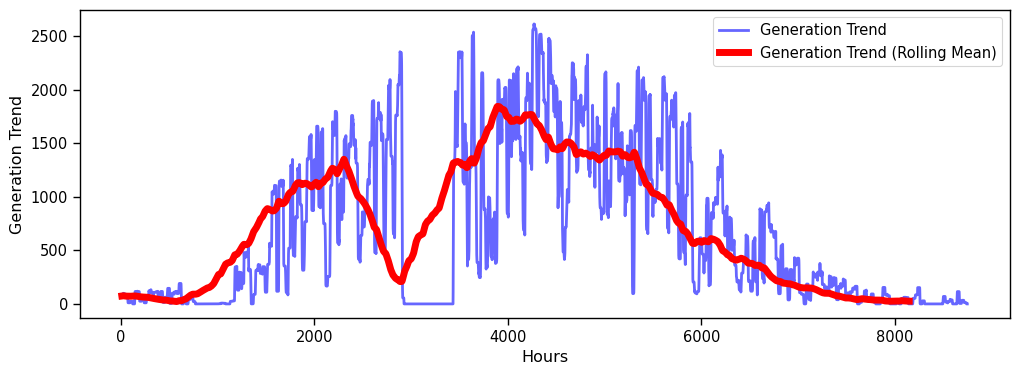

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf

decomposed_results = seasonal_decompose(df["SystemProduction"], period=24)

fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(decomposed_results.trend, alpha=0.6, color='Blue', label='Generation Trend', linewidth = 2.0)
ax.plot(decomposed_results.trend.rolling(600).mean().shift(-600), alpha=1, color='Red', label='Generation Trend (Rolling Mean)', linewidth = 5.0)
ax.legend(loc='best')
ax.set_ylabel("Generation Trend")
ax.set_xlabel("Hours")
plt.show()

- view the first 400 data (샘플은 시간 단위)

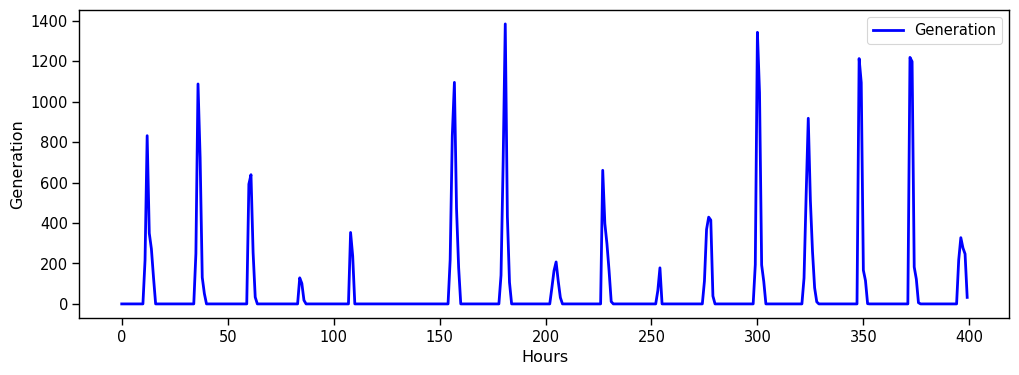

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df["SystemProduction"][:400], alpha=1, color='blue', label='Generation', linewidth = 2.0)
ax.legend(loc='best')
ax.set_ylabel("Generation")
ax.set_xlabel("Hours")
plt.show()

- Q-Q plot:데이터의 분포가 특정 분포(주로 정규분포)를 따르는지 시각적으로 확인

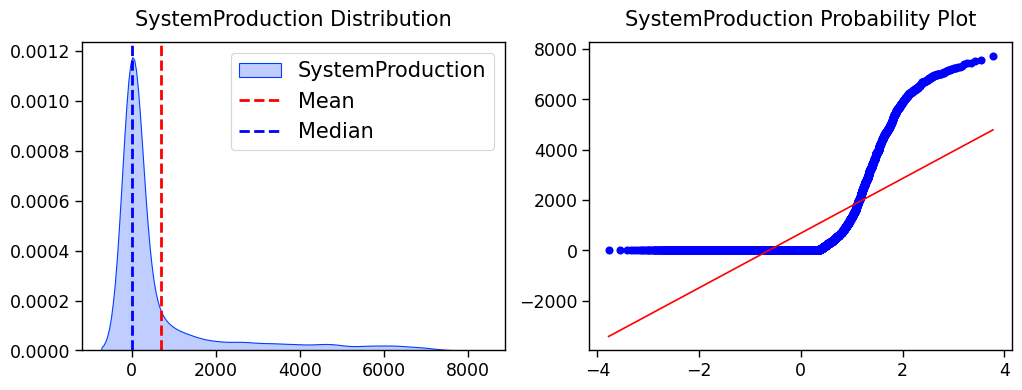

In [ ]:
import scipy.stats as stats

target = 'SystemProduction'
fig, axes = plt.subplots(ncols=2, figsize=(12, 4), dpi=100)

sns.kdeplot(df[target], label=target, fill=True, ax=axes[0])
axes[0].axvline(df[target].mean(), label='Mean', color='r', linewidth=2, linestyle='--')
axes[0].axvline(df[target].median(), label='Median', color='b', linewidth=2, linestyle='--')
axes[0].legend(prop={'size': 15})
stats.probplot(df[target], plot=axes[1], dist='norm')

for i in range(2):
    axes[i].tick_params(axis='x', labelsize=12.5)
    axes[i].tick_params(axis='y', labelsize=12.5)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('')
axes[0].set_title(f'{target} Distribution', fontsize=15, pad=12)
axes[1].set_title(f'{target} Probability Plot', fontsize=15, pad=12)

plt.show()


- Q-Q Plot: 직선에 가까울수록 정규분포에 가깝다는 것을 의미함

## Baseline model
- try Linear Regression with the raw data -> Baseline model
- no scaling, no feature engineering

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, SGDRegressor

X = df.drop(['SystemProduction', 'Date-Hour(NMT)'], axis=1)
y = df['SystemProduction']

In [ ]:
import statsmodels.api as sm     # Linear Regression (OLS)
from sklearn.metrics import r2_score

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# 학습 데이터에 상수 열 추가 (절편 항 추가): 일반적으로 스케일링 후에
X_train = sm.add_constant(X_train)
X_test = sm.add_constant(X_test)

# OLS 모델 학습
linreg_model = sm.OLS(y_train, X_train)
results = linreg_model.fit()
print(results.summary())

# 예측 수행
y_pred_train = results.predict(X_train)
y_pred_test = results.predict(X_test)

# 평가 메트릭 계산 (R^2)
train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print(f'Train R^2: {train_r2}')
print(f'Test R^2: {test_r2}')

                            OLS Regression Results                            
Dep. Variable:       SystemProduction   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     2084.
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        06:53:10   Log-Likelihood:                -57635.
No. Observations:                7008   AIC:                         1.153e+05
Df Residuals:                    7001   BIC:                         1.153e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                6036.8155    

In [ ]:
lin_model = LinearRegression()
lin_model.fit(X_train, y_train)
print(lin_model.coef_, lin_model.intercept_)
lin_model.score(X_train, y_train), lin_model.score(X_test, y_test)

[  0.          12.08893551 -10.04079057  -5.22095432   6.49203211
  11.36952889  -9.21317151] 6036.815453717569


(0.6411030646395175, 0.6122642021271074)

In [ ]:
# SGDRegressor() model is very sensitive to feature scaling
# if not scaled, it may not converge.

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

lin_model = SGDRegressor()
lin_model.fit(X_train, y_train)
print(lin_model.coef_, lin_model.intercept_)
lin_model.score(X_train, y_train), lin_model.score(X_test, y_test)

[   0.            9.76285638 -200.33574098  -47.53004114 1217.94036972
   85.48624031 -169.77502614] [713.01928346]


(0.6404294357710648, 0.6101377379185422)

- OLS and Gradient Descent method
  - OLS는 일반적으로 더 안정적이며 closed solution을 제공하므로 작은 데이터 세트 또는 계산 리소스가 충분한 경우에 이상적이다. 데이터가 특정 조건(예: 완벽한 다중공선성 없음)을 충족하는 경우 선형 회귀 문제에 대한 정확한 솔루션을 제공한다.  
  - 경사 하강법: 경사 하강법은 더 유연하고 확장 가능하므로 **대규모 데이터 세트** 또는 closed solution이 계산적으로 비실용적인 상황에 적합하다. 그러나 하이퍼파라미터를 신중하게 조정해야 하며 적절하게 구성하지 않으면 안정성이 떨어질 수 있다.

## Feature engineering:
다음 피처들을 추가해 보자.
- "Season: Spring, Summer, Autumn, Winter"
- "Day or Night"

In [ ]:
df.dtypes

,0
Date-Hour(NMT),datetime64[ns]
WindSpeed,float64
Sunshine,int64
AirPressure,float64
Radiation,float64
AirTemperature,float64
RelativeAirHumidity,int64
SystemProduction,float64


In [ ]:
# df['Dates'] = df['Date-Hour(NMT)'].dt.date
df['Hour'] = df['Date-Hour(NMT)'].dt.hour
# df['Day'] = df['Date-Hour(NMT)'].dt.day
df['Month'] = df['Date-Hour(NMT)'].dt.month
# df['Year'] = df['Date-Hour(NMT)'].dt.year
df["Season"] = [ "Winter" if i < 3 or i > 11 else
                 "Spring" if 3 <= i < 6 else
                 "Summer" if 6 <= i < 9 else
                 "Autumn" for i in df["Month"]]
pd.concat([df.head(3), df.tail(3)])

,Date-Hour(NMT),WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,Hour,Month,Season
0,2017-01-01 00:00:00,0.60000000,0,1003.80000000,-7.40000000,0.10000000,97,0.00000000,0,1,Winter
1,2017-01-01 01:00:00,1.70000000,0,1003.50000000,-7.40000000,-0.20000000,98,0.00000000,1,1,Winter
2,2017-01-01 02:00:00,0.60000000,0,1003.40000000,-6.70000000,-1.20000000,99,0.00000000,2,1,Winter
8757,2017-12-31 21:00:00,1.80000000,0,986.70000000,-5.30000000,0.20000000,93,0.00000000,21,12,Winter
8758,2017-12-31 22:00:00,2.20000000,0,986.00000000,-5.40000000,0.30000000,92,0.00000000,22,12,Winter
8759,2017-12-31 23:00:00,2.40000000,0,985.60000000,-5.90000000,0.40000000,96,0.00000000,23,12,Winter


In [ ]:
df_DnN = df.groupby(["Season", "Hour","SystemProduction"], as_index = False)["SystemProduction"].mean()
df_DnN = df_DnN.sort_values(by="Hour",ascending = False)
pd.concat([df_DnN.head(3), df_DnN.tail(3)])

,Season,Hour,SystemProduction
3050,Summer,23,0.62500000
3049,Summer,23,0.00000000
3360,Winter,23,0.00000000
3051,Winter,0,0.00000000
734,Spring,0,0.00000000
1611,Summer,0,0.00000000


In [ ]:
table = pd.pivot_table(df_DnN, values = "SystemProduction", columns = "Season", index = "Hour", aggfunc = np.mean )
table

Season,Autumn,Spring,Summer,Winter
Hour,,,,
0,0.00000000,0.00000000,0.00000000,0.00000000
1,0.00000000,0.00000000,0.00000000,0.00000000
2,0.00000000,0.00000000,0.00000000,0.00000000
3,0.00000000,0.00000000,0.00000000,0.00000000
4,0.00000000,0.00000000,0.00000000,0.00000000
5,0.00000000,0.00000000,55.75000000,0.00000000
6,0.00000000,85.16664000,129.37280789,0.00000000
7,0.00000000,240.83332500,304.49285571,0.00000000
8,99.78473333,326.01458500,579.79544886,0.00000000


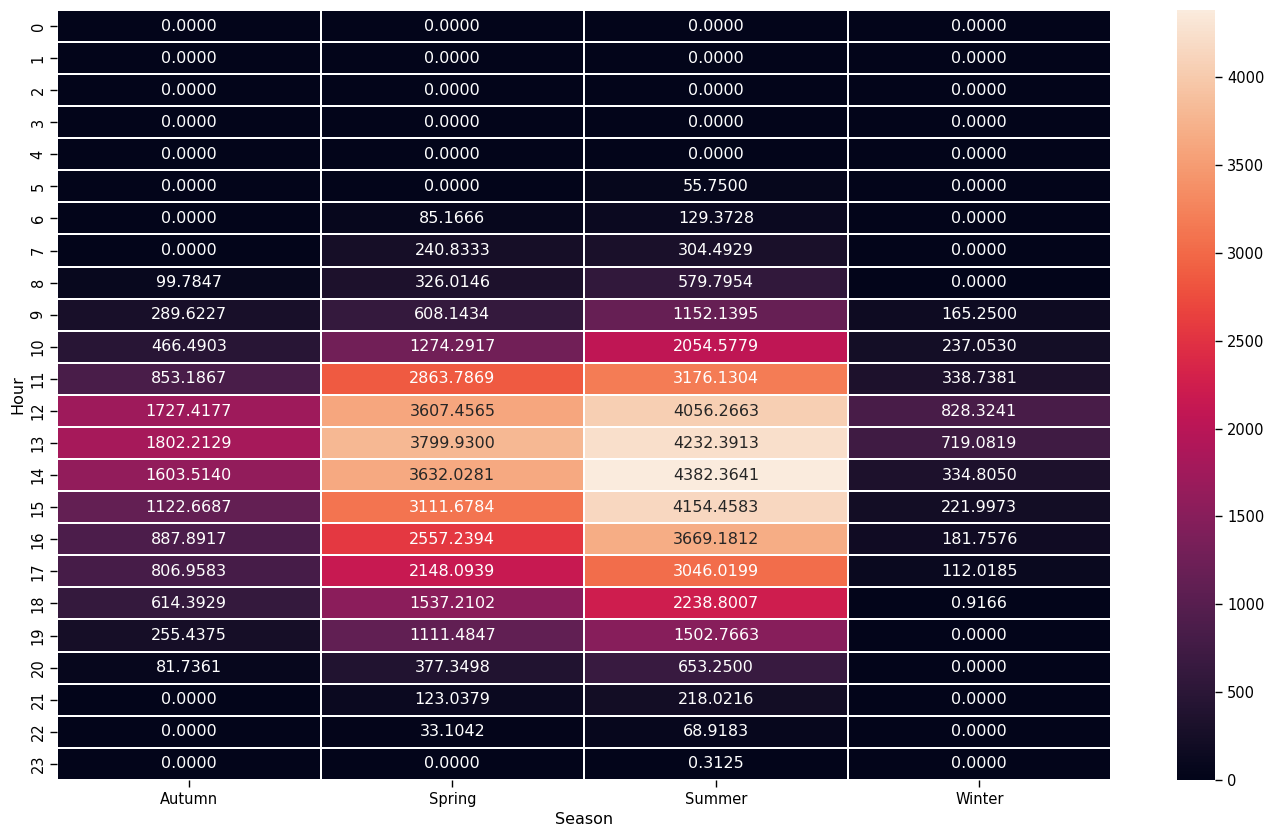

In [ ]:
plt.figure(figsize=(17,10))
sns.heatmap(table, annot = True, fmt = ".4f", linewidth = 0.2 ); #

- 계절에 따라 시간대를 주간, 야간으로 구별해 보자

In [ ]:
df.loc[((df["Hour"] > 8) & (df['Hour'] < 18)) & (df['Season']=='Winter'), 'Time'] = 'Day'
df.loc[((df["Hour"] > 6) & (df['Hour'] < 22)) & (df['Season']=='Spring'), 'Time'] = 'Day'
df.loc[((df["Hour"] > 5) & (df['Hour'] < 22)) & (df['Season']=='Summer'), 'Time'] = 'Day'
df.loc[((df["Hour"] > 7) & (df['Hour'] < 20)) & (df['Season']=='Autumn'), 'Time'] = 'Day'

df.loc[((df["Hour"] <= 8) | (df['Hour'] >= 18)) & (df['Season']=='Winter'), 'Time'] = 'Night'
df.loc[((df["Hour"] <= 6) | (df['Hour'] >= 22)) & (df['Season']=='Spring'), 'Time'] = 'Night'
df.loc[((df["Hour"] <= 5) | (df['Hour'] >= 22)) & (df['Season']=='Summer'), 'Time'] = 'Night'
df.loc[((df["Hour"] <= 7) | (df['Hour'] >= 20)) & (df['Season']=='Autumn'), 'Time'] = 'Night'

pd.concat([df.head(3), df.tail(3)])

,Date-Hour(NMT),WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,Hour,Month,Season,Time
0,2017-01-01 00:00:00,0.60000000,0,1003.80000000,-7.40000000,0.10000000,97,0.00000000,0,1,Winter,Night
1,2017-01-01 01:00:00,1.70000000,0,1003.50000000,-7.40000000,-0.20000000,98,0.00000000,1,1,Winter,Night
2,2017-01-01 02:00:00,0.60000000,0,1003.40000000,-6.70000000,-1.20000000,99,0.00000000,2,1,Winter,Night
8757,2017-12-31 21:00:00,1.80000000,0,986.70000000,-5.30000000,0.20000000,93,0.00000000,21,12,Winter,Night
8758,2017-12-31 22:00:00,2.20000000,0,986.00000000,-5.40000000,0.30000000,92,0.00000000,22,12,Winter,Night
8759,2017-12-31 23:00:00,2.40000000,0,985.60000000,-5.90000000,0.40000000,96,0.00000000,23,12,Winter,Night


In [ ]:
df = df.drop(['Date-Hour(NMT)', 'Hour', 'Month'],axis=1)
df.head(3)

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,Season,Time
0,0.60000000,0,1003.80000000,-7.40000000,0.10000000,97,0.00000000,Winter,Night
1,1.70000000,0,1003.50000000,-7.40000000,-0.20000000,98,0.00000000,Winter,Night
2,0.60000000,0,1003.40000000,-6.70000000,-1.20000000,99,0.00000000,Winter,Night


In [ ]:
!pip install category_encoders

In [ ]:
import category_encoders as ce    # 더 다양한 기능 (예: 결측값을 허용하며, 결측값도 별도의 숫자 값으로 인코딩)

encoder = ce.OrdinalEncoder(cols=['Season','Time'])
df = encoder.fit_transform(df)
df.sample(5)

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,Season,Time
525,1.60000000,0,1019.50000000,-5.70000000,-0.20000000,99,0.00000000,1,1
3816,2.40000000,0,1010.10000000,-6.10000000,11.60000000,87,0.00000000,3,1
93,4.80000000,0,1022.20000000,-5.00000000,-5.60000000,73,0.00000000,1,1
5566,1.00000000,0,1009.90000000,-6.80000000,14.40000000,89,0.00000000,3,1
1106,0.40000000,0,1025.40000000,-5.00000000,-4.50000000,97,0.00000000,1,1


## Split the data (X and y)

In [ ]:
X, y = df.drop(['SystemProduction'],axis=1), df['SystemProduction']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

In [ ]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from xgboost import plot_importance
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.8f' % x)

## Models

In [ ]:
X_train.head()

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,Season,Time
8415,0.70000000,14,1013.80000000,12.20000000,-6.50000000,90,1,2
5049,1.70000000,0,1005.50000000,136.10000000,15.90000000,83,3,2
8395,3.00000000,0,1008.90000000,-7.20000000,-2.80000000,70,1,1
1535,4.90000000,0,1014.70000000,-5.10000000,-2.30000000,59,2,1
5518,1.80000000,0,1005.50000000,-6.80000000,16.10000000,94,3,1


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Linear Regression (OLS)
import statsmodels.api as sm

# build a full model using OLS()
linreg_full_model = sm.OLS(y_train, X_train).fit()

# print the summary output
print(linreg_full_model.summary())

                                 OLS Regression Results                                
Dep. Variable:       SystemProduction   R-squared (uncentered):                   0.529
Model:                            OLS   Adj. R-squared (uncentered):              0.528
Method:                 Least Squares   F-statistic:                              981.0
Date:                Fri, 29 Nov 2024   Prob (F-statistic):                        0.00
Time:                        06:53:13   Log-Likelihood:                         -59271.
No. Observations:                7008   AIC:                                  1.186e+05
Df Residuals:                    7000   BIC:                                  1.186e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------

In [ ]:
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

In [ ]:
models = []

names = [
    "LinearRegression",
    "RidgeCV",                     # built-in CV, alpha is automatically determined
    "Ridge",
    "LassoCV",
    "Lasso",
    "ElasticNetCV",
    "ElasticNet",
    "LinearSVR",

    "KNeighborsRegressor",         # knn
    "DecisionTreeRegressor",
    "RandomForestRegressor",
    "GradientBoostingRegressor",
    "AdaBoostRegressor",
    "ExtraTreeRegressor",        # a single tree, splits data randomly

    "BaggingRegressor",
    "MLPRegressor"               # default 100 neurons in hidden, 1 node for output
]

scores = []

clf = [
    LinearRegression(),
    RidgeCV(),
    Ridge(),
    LassoCV(),
    Lasso(alpha=0.1),
    ElasticNetCV(),
    ElasticNet(),
    LinearSVR(),

    KNeighborsRegressor(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    GradientBoostingRegressor(),
    AdaBoostRegressor(),
    ExtraTreeRegressor(),

    BaggingRegressor(),
    MLPRegressor()
]

In [ ]:
%%time
for model in clf:
    model.fit(X_train, y_train)
    score = model.score(X_test, y_test)
    scores.append(score)

final_scores = pd.DataFrame(zip(names,scores), columns=['Classifier', 'Accuracy'])

final_scores.sort_values(by='Accuracy',ascending=False)

CPU times: user 221 ms, sys: 755 µs, total: 222 ms
Wall time: 396 ms


,Classifier,Accuracy
10,RandomForestRegressor,0.75145992
14,BaggingRegressor,0.72556294
8,KNeighborsRegressor,0.72407485
11,GradientBoostingRegressor,0.70271505
15,MLPRegressor,0.64089522
12,AdaBoostRegressor,0.62914447
3,LassoCV,0.61342474
1,RidgeCV,0.61339829
2,Ridge,0.61339829
4,Lasso,0.61339610


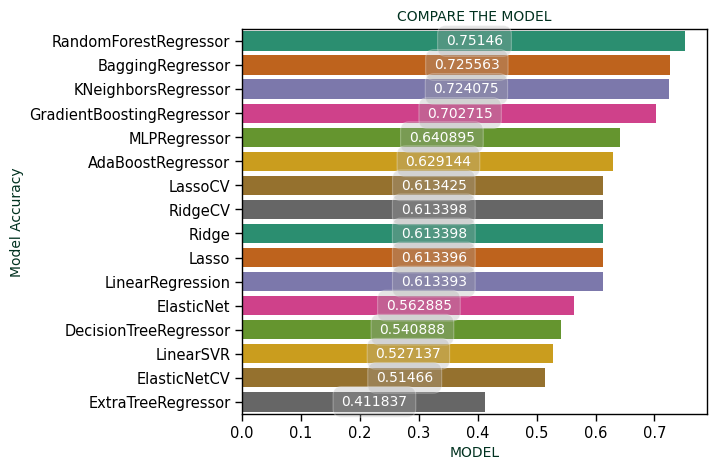

In [ ]:
p = plt.figure(figsize=(6,5))
p = sns.set_palette('bright')
p = sns.set_context('paper', font_scale=1.2)

p = models=final_scores.sort_values(by='Accuracy',ascending=False)

p = sns.barplot(y= 'Classifier', x= 'Accuracy', data= models,palette='Dark2')

for container in p.containers:
    p.bar_label(container,label_type = 'center',padding = 8,size = 10,color = "White",rotation = 0,
    bbox={"boxstyle": "round", "pad": 0.6, "facecolor": "#a9a9a9", "edgecolor": "white", "alpha": .3})

plt.title('COMPARE THE MODEL',fontsize=10,color='#013220')
plt.xlabel('MODEL',fontsize=10,color='#013220')
plt.ylabel('Model Accuracy',fontsize=10,color='#013220');

## Altogether


### Base model:
  - no feature transform
  - no target transform
  - linear model (OLS model)


In [ ]:
df = pd.read_csv('Solar.csv')
df['Date-Hour(NMT)'] = pd.to_datetime(df['Date-Hour(NMT)'], format='%d.%m.%Y-%H:%M')

X = df.drop(['SystemProduction', 'Date-Hour(NMT)'], axis=1)
y = df['SystemProduction']
print(X.columns)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

# training the model with the train data
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_train_ols = sm.add_constant(X_train)

base_model = sm.OLS(y_train, X_train_ols).fit()
print(base_model.summary())

# performance evaluation with the test data
X_test = sc.transform(X_test)
X_test_ols = sm.add_constant(X_test)

y_pred_train = base_model.predict(X_train_ols)
y_pred_test = base_model.predict(X_test_ols)

train_r2 = r2_score(y_train, y_pred_train)
test_r2 = r2_score(y_test, y_pred_test)

print()
print("Baseline Model Performance:")
print(f'Train R^2: {train_r2}')
print(f'Test R^2: {test_r2}')

Index(['WindSpeed', 'Sunshine', 'AirPressure', 'Radiation', 'AirTemperature',
       'RelativeAirHumidity'],
      dtype='object')
                            OLS Regression Results                            
Dep. Variable:       SystemProduction   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.641
Method:                 Least Squares   F-statistic:                     2084.
Date:                Fri, 29 Nov 2024   Prob (F-statistic):               0.00
Time:                        06:53:51   Log-Likelihood:                -57635.
No. Observations:                7008   AIC:                         1.153e+05
Df Residuals:                    7001   BIC:                         1.153e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]


In [ ]:
from sklearn.linear_model import LinearRegression, SGDRegressor

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)
print(f"*** Coefficients: ***\n {lin_reg.coef_} {lin_reg.intercept_}")
print("\n*** Baseline model Performance: ***")
lin_reg.score(X_train, y_train), lin_reg.score(X_test, y_test)

*** Coefficients: ***
 [  19.74360381 -214.22577827  -66.75105147 1196.08693316   86.60551667
 -177.89481227] 697.0526419663244

*** Baseline model Performance: ***


(0.6411030646395175, 0.6122642021271074)

In [ ]:
# SGDRegressor() model is very sensitive to feature scaling
# if not scaled, it may not converge.

sgd_reg = SGDRegressor(learning_rate='constant',
                       eta0=1e-3,
                       max_iter=1000,
                       alpha=0.0001,
                       random_state=42,
                       )
sgd_reg.fit(X_train, y_train)
sgd_reg.score(X_train, y_train), sgd_reg.score(X_test, y_test)

(0.6405700759610604, 0.611998906429076)

- the performance of the base model is 0.61

In [ ]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor()
rf_reg.fit(X_train, y_train)
print(X.columns)
print(rf_reg.feature_importances_)
rf_reg.score(X_train, y_train), rf_reg.score(X_test, y_test)

Index(['WindSpeed', 'Sunshine', 'AirPressure', 'Radiation', 'AirTemperature',
       'RelativeAirHumidity'],
      dtype='object')
[0.05264089 0.03483338 0.08015703 0.67333756 0.09332282 0.06570833]


(0.9634681553011053, 0.7178279718520395)

In [ ]:
from sklearn.svm import SVR

svm_reg = SVR(kernel='rbf', C=100, gamma=0.01, epsilon=0.0001)
svm_reg.fit(X_train, y_train)
svm_reg.score(X_train, y_train), svm_reg.score(X_test, y_test)

(0.6238995174375868, 0.6009439760009546)

In [ ]:
# note that it takes long time
from sklearn.model_selection import GridSearchCV
param_grid = {
    'C': [0.1, 1, 10, 100],
    #'gamma': [0.001, 0.01, 0.1, 1],
    #'epsilon': [0.01, 0.1, 0.5, 1],
    'kernel': ['rbf']
}
grid_search = GridSearchCV(SVR(), param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best R^2 score from GridSearch: {grid_search.best_score_}")

Best parameters: {'C': 100, 'kernel': 'rbf'}
Best R^2 score from GridSearch: 0.65798996393214


In [ ]:
svm_reg = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=1)
svm_reg.fit(X_train, y_train)
svm_reg.score(X_train, y_train), svm_reg.score(X_test, y_test)

(0.6705291838047285, 0.6337102060073556)

- We got the following results:
  - Best parameters: {'C': 100, 'epsilon': 1, 'gamma': 0.1, 'kernel': 'rbf'}
  - Best R^2 score from GridSearch: 0.6627432418984294

In [ ]:
!pip install category_encoders

### Feature engineering
- create extra categorical columns: 'Season', 'Time' (all ordinal encoded)

In [ ]:
df = pd.read_csv('Solar.csv')
df['Date-Hour(NMT)'] = pd.to_datetime(df['Date-Hour(NMT)'], format='%d.%m.%Y-%H:%M')
X, y = df.drop('SystemProduction', axis=1), df['SystemProduction']

In [ ]:
X.head()

,Date-Hour(NMT),WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity
0,2017-01-01 00:00:00,0.60000000,0,1003.80000000,-7.40000000,0.10000000,97
1,2017-01-01 01:00:00,1.70000000,0,1003.50000000,-7.40000000,-0.20000000,98
2,2017-01-01 02:00:00,0.60000000,0,1003.40000000,-6.70000000,-1.20000000,99
3,2017-01-01 03:00:00,2.40000000,0,1003.30000000,-7.20000000,-1.30000000,99
4,2017-01-01 04:00:00,4.00000000,0,1003.10000000,-6.30000000,3.60000000,67


In [ ]:
# create two extra categoricl features ('Time' and 'Season')
from sklearn.base import BaseEstimator, TransformerMixin

class AddTwoFeatures(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self  # Nothing to fit here, so return self

    def transform(self, X_org):
        # Add the two features and return the modified DataFrame
        X = X_org.copy()
        if 'Date-Hour(NMT)' in X.columns:
            X['Dates'] = X_org['Date-Hour(NMT)'].dt.date
            X['Hour'] = X_org['Date-Hour(NMT)'].dt.hour
            X['Day'] = X_org['Date-Hour(NMT)'].dt.day
            X['Month'] = X_org['Date-Hour(NMT)'].dt.month
            X['Year'] = X_org['Date-Hour(NMT)'].dt.year
            X["Season"] = [ "Winter" if i < 3 or i > 11 else
                            "Spring" if 3 <= i < 6 else
                            "Summer" if 6 <= i < 9 else
                            "Autumn" for i in X["Month"]]
        else:
            print(f"Error: Column 'Date-Hour(NMT)' not found in DataFrame.")
            return X_org

        X.loc[((X["Hour"] > 8) & (X['Hour'] < 18)) & (X['Season']=='Winter'), 'Time'] = 'Day'
        X.loc[((X["Hour"] > 6) & (X['Hour'] < 22)) & (X['Season']=='Spring'), 'Time'] = 'Day'
        X.loc[((X["Hour"] > 5) & (X['Hour'] < 22)) & (X['Season']=='Summer'), 'Time'] = 'Day'
        X.loc[((X["Hour"] > 7) & (X['Hour'] < 20)) & (X['Season']=='Autumn'), 'Time'] = 'Day'
        X.loc[((X["Hour"] <= 8) | (X['Hour'] >= 18)) & (X['Season']=='Winter'), 'Time'] = 'Night'
        X.loc[((X["Hour"] <= 6) | (X['Hour'] >= 22)) & (X['Season']=='Spring'), 'Time'] = 'Night'
        X.loc[((X["Hour"] <= 5) | (X['Hour'] >= 22)) & (X['Season']=='Summer'), 'Time'] = 'Night'
        X.loc[((X["Hour"] <= 7) | (X['Hour'] >= 20)) & (X['Season']=='Autumn'), 'Time'] = 'Night'

        X = X.drop('Date-Hour(NMT)', axis=1)
        X = X.drop(['Dates', 'Hour', 'Day','Month', 'Year'], axis=1)

        return X


In [ ]:
# just for checking
addfeatures= AddTwoFeatures()
X2 = addfeatures.fit_transform(X)
X2.tail(5)

,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,Season,Time
8755,4.10000000,0,988.20000000,-4.80000000,-0.70000000,94,Winter,Night
8756,2.10000000,0,987.30000000,-5.00000000,-0.30000000,95,Winter,Night
8757,1.80000000,0,986.70000000,-5.30000000,0.20000000,93,Winter,Night
8758,2.20000000,0,986.00000000,-5.40000000,0.30000000,92,Winter,Night
8759,2.40000000,0,985.60000000,-5.90000000,0.40000000,96,Winter,Night


In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from scipy.special import boxcox, inv_boxcox
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import category_encoders as ce

# preprocessing numerical and categorical features
categorical_cols = ['Season','Time']
numerical_cols = ['WindSpeed', 'Sunshine', 'AirPressure', 'Radiation', 'AirTemperature',
                  'RelativeAirHumidity']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', ce.OrdinalEncoder(), categorical_cols)
    ])

full_pipeline = Pipeline(steps=[
        ('add_features', AddTwoFeatures()),
        ('preprocessor', preprocessor)
    ])


In [ ]:
preprocessor.fit_transform(X2)[-2:]

array([[-0.27005194, -0.5281263 , -1.90426964, -0.564586  , -0.87835883,
         0.79264844,  1.        ,  1.        ],
       [-0.14725168, -0.5281263 , -1.93553615, -0.56732835, -0.86520756,
         1.00013997,  1.        ,  1.        ]])

In [ ]:
full_pipeline.fit_transform(X)[-2:]   # the same as the above

array([[-0.27005194, -0.5281263 , -1.90426964, -0.564586  , -0.87835883,
         0.79264844,  1.        ,  1.        ],
       [-0.14725168, -0.5281263 , -1.93553615, -0.56732835, -0.86520756,
         1.00013997,  1.        ,  1.        ]])

### Training and Performance
- 여러 모델을 실습하기 위해 최종 estimator (classifier)는 Pipeline()에 추가하지 않음

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=.2, random_state=42)

X_train_transformed = full_pipeline.fit_transform(X_train)
lin_reg = LinearRegression()
lin_reg.fit(X_train_transformed, y_train)
print(f"Train score: {lin_reg.score(X_train_transformed, y_train)}")

# for the test set
X_test_transformed = full_pipeline.transform(X_test)
y_pred = lin_reg.predict(X_test_transformed)
print(f"Test score: {r2_score(y_test, y_pred)}")

# or
lin_reg.score(X_test_transformed, y_test)

Train score: 0.6419704945340632
Test score: 0.6141988616933791


0.6141988616933791

In [ ]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_transformed, y_train)
print(f"Train score: {rf_reg.score(X_train_transformed, y_train)}")

y_pred = rf_reg.predict(X_test_transformed)
print(f"Test score: {r2_score(y_test, y_pred)}")
# or
# print(f"Test score: {rf_reg.score(X_test_transformed, y_test)}")

Train score: 0.9666062054904355
Test score: 0.7441167620487368


In [ ]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train_transformed, y_train)
print(f"Train score: {gb_reg.score(X_train_transformed, y_train)}")

y_pred = gb_reg.predict(X_test_transformed)
print(f"Test score: {r2_score(y_test, y_pred)}")

Train score: 0.7978755471765677
Test score: 0.7034588823303709


- now we make a target transform.

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.2,random_state=42)

# Apply log transformation to the target on the training set
shift_value = 1  # to avoid 0
y_train_log = np.log(y_train + shift_value)
y_test_log = np.log(y_test + shift_value)

lin_reg = LinearRegression()
lin_reg.fit(X_train_transformed, y_train_log)
print(f"Train score: {lin_reg.score(X_train_transformed, y_train_log)}")

# for the test set
X_test_transformed = full_pipeline.transform(X_test)
y_pred = lin_reg.predict(X_test_transformed)
print(f"Test score: {r2_score(y_test_log, y_pred)}")


Train score: 0.6345272905696278
Test score: 0.597497921338688


- got worse than no transformation case

In [ ]:
sgd_reg = SGDRegressor(learning_rate='constant',
                       eta0=1e-3,
                       max_iter=1000,
                       alpha=0.0001,
                       random_state=42,
                       )
sgd_reg.fit(X_train_transformed, y_train_log)
print(f"Train score: {sgd_reg.score(X_train_transformed, y_train_log)}")

# for the test set
X_test_transformed = full_pipeline.transform(X_test)
y_pred = sgd_reg.predict(X_test_transformed)
print(f"Test score: {r2_score(y_test_log, y_pred)}")

Train score: 0.6276922530539402
Test score: 0.585565357281874


In [ ]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_transformed, y_train_log)
print(f"Train score: {rf_reg.score(X_train_transformed, y_train_log)}")

y_pred = rf_reg.predict(X_test_transformed)
print(f"Test score: {r2_score(y_test_log, y_pred)}")

Train score: 0.9764490207052752
Test score: 0.8134756777749285


- so far, the best

In [ ]:
gb_reg = GradientBoostingRegressor()
gb_reg.fit(X_train_transformed, y_train_log)
print(f"Train score: {gb_reg.score(X_train_transformed, y_train_log)}")

y_pred = gb_reg.predict(X_test_transformed)
print(f"Test score: {r2_score(y_test_log, y_pred)}")

Train score: 0.8143341298872102
Test score: 0.7663235354005814


- RandomForest model: not sensitive to skewness in the data (No Assumption of Normality)

## 요약
- Log Transformation은 대상 변수의 왜도나 이분산성 (분산이 일정하지 않은 현상)을 해결하여 RandomForest가 관계를 더 효과적으로 모델링할 수 있었기 때문에 잘 작동한 걸로 보임.
- RandomForest는 선형 모델에 필요한 엄격한 가정이 필요 없이 복잡하고 비선형적인 관계를 처리할 수 있는 강력하고 non-parametric 모델인 효과.

- Why Use Negative MSE (neg_mean_squared_error)?
  - The reason for using negative MSE is rooted in how scikit-learn handles scoring metrics: Maximization by Default in scikit-learn
  - In scikit-learn, metrics are expected to be maximized during cross-validation or grid search.
    - For classification, scores like accuracy, precision, or recall are maximized.
    - For regression, metrics like MSE (or RMSE) are naturally minimized.
  - To make MSE compatible with the framework, scikit-learn converts it into a negative value.
  - This allows the cross-validation process to maximize the "negative MSE," which is equivalent to minimizing the MSE.

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [None, 5, 7, 10]
}

grid_search = GridSearchCV(estimator=rf_reg,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)
grid_search.fit(X_train_transformed, y_train_log)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

Best Parameters: {'max_depth': None, 'max_features': 'log2', 'n_estimators': 200}
Best Score: -1.9972589071947155


In [ ]:
rf_reg_tuned = RandomForestRegressor(max_depth= None,
                                     max_features= 'log2',
                                     n_estimators= 200)

print("With the tuned RandomForest Regressor:")
rf_reg_tuned.fit(X_train_transformed, y_train_log)
print(f"Train score: {rf_reg_tuned.score(X_train_transformed, y_train_log)}")

y_pred = rf_reg_tuned.predict(X_test_transformed)
print(f"Test score: {r2_score(y_test_log, y_pred)}")

With the tuned RandomForest Regressor:
Train score: 0.9772961665296447
Test score: 0.8159541242538123


# Exercise

## groupby() function
- 데이터를 특정 기준으로 그룹화하는 데 사용
- 그룹화된 데이터에 대해 요약 통계(평균, 합계 등)를 계산하거나 특정 작업을 수행

In [ ]:
import pandas as pd

# Sample DataFrame
data = pd.DataFrame({
    'Company': ['Apple', 'Google', 'Apple', 'Microsoft', 'Google'],
    'Employee': ['Steve', 'Sundar', 'Tim', 'Satya', 'Larry'],
    'Sales': [200, 150, 240, 300, 200]
})
data

,Company,Employee,Sales
0,Apple,Steve,200
1,Google,Sundar,150
2,Apple,Tim,240
3,Microsoft,Satya,300
4,Google,Larry,200


In [ ]:
# Group by the 'Company' column and sum up the colum values
data.groupby('Company').sum()

,Employee,Sales
Company,,
Apple,SteveTim,440
Google,SundarLarry,350
Microsoft,Satya,300


In [ ]:
# Group by the 'Company' column and sum up the sales
data.groupby('Company')['Sales'].sum()

,Sales
Company,
Apple,440
Google,350
Microsoft,300


In [ ]:
data.groupby('Company')['Employee'].sum()

,Employee
Company,
Apple,SteveTim
Google,SundarLarry
Microsoft,Satya


In [ ]:
data.groupby(['Company','Employee'])['Sales'].sum()

Company    Employee
Apple      Steve       200
           Tim         240
Google     Larry       200
           Sundar      150
Microsoft  Satya       300
Name: Sales, dtype: int64

## pivot_table()
- 데이터를 행과 열로 분류하여 특정 값의 통계를 계산한다.
- 그룹화된 데이터에 대해 평균, 합계, 개수, 표준편차 등을 손쉽게 구할 수 있다.
- group_by()와 비슷하지만 결과를 테이블 형태로 정리한다.

In [ ]:
# Sample DataFrame
data = {'Product': ['A', 'B', 'A', 'B', 'A', 'B'],
        'Region': ['North', 'South', 'North', 'South', 'North', 'South'],
        'Sales': [100, 150, 120, 180, 90, 200]}
df = pd.DataFrame(data)
df

,Product,Region,Sales
0,A,North,100
1,B,South,150
2,A,North,120
3,B,South,180
4,A,North,90
5,B,South,200


In [ ]:
# Create a pivot table
pivot_table = pd.pivot_table(df, values='Sales', index='Product', columns='Region', aggfunc=np.sum)
print(pivot_table)

Region         North        South
Product                          
A       310.00000000          NaN
B                NaN 530.00000000


In [ ]:
df.groupby(['Product','Region'])['Sales'].sum()

,,Sales
Product,Region,
A,North,310
B,South,530


## Pipeline()
- 전처리 단계(transformer)와 모델 학습 또는 predictor 를 연결하여 워크플로를 간소화하기 위한 것
- 파이프라인의 최종 출력은 주로 predictor 를 적용한 결과이며, 이는 regression, classification 모델 평가이다
- Scikit-learn의 Pipeline을 사용할 때는 파이프라인의 마지막 단계에 있는 클래스(주로 Estimator)의 함수를 호출
- 마지막 단계가 transformer 이면 transform() 사용

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=100, n_features=10, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline 정의
pipeline = Pipeline([
    ('scaler', StandardScaler()),              # Transformer
    ('classifier', RandomForestClassifier())   # Estimator
])

# 학습
pipeline.fit(X_train, y_train)

# 예측 (마지막 단계의 RandomForestClassifier의 predict 메서드를 호출)
y_pred = pipeline.predict(X_test)

# 평가 (마지막 단계의 score 메서드를 호출)
accuracy = pipeline.score(X_test, y_test)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


- 중간단계 접근

In [ ]:
pipeline.named_steps

{'scaler': StandardScaler(), 'classifier': RandomForestClassifier()}

In [ ]:
# StandardScaler 객체에 접근
scaler = pipeline.named_steps['scaler']
clf = pipeline.named_steps['classifier']

# StandardScaler의 transform 메서드 호출
scaled_data = scaler.transform(X_test[:3])
clf.predict(scaled_data)

array([0, 1, 1])

In [ ]:
pipeline.predict(X_test[:3])  # the same as the above (easier to manage)

array([0, 1, 1])

## Custom Transformer 정의
- BaseEstimator, TransformerMixin 클라스 상속
- BaseEstimator: 모든 estimator 의 기본 class
  - 생성자로부터 받은 parameter 자동 저장 등. (get_params(), set_params())
- TransformerMixin: 모든 transformer 의 기본 class
  - fit_transform() 등 제공
- Scikit-learn의 Pipeline()과 호환 사용

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

class AddTwoFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, feature1, feature2, new_feature_name="sum_feature"):
        self.feature1 = feature1
        self.feature2 = feature2
        self.new_feature_name = new_feature_name

    def fit(self, X, y=None):
        # fit 메서드는 변환기에 학습 과정이 필요한 경우 구현, 여기서는 없음
        return self

    def transform(self, X):
        # 두 피처의 합을 계산하여 새로운 열로 추가
        new_feature = X[self.feature1] + X[self.feature2]
        X[self.new_feature_name] = new_feature
        return X

In [ ]:
import pandas as pd
from sklearn.pipeline import Pipeline

data = pd.DataFrame({
    "Feature1": [1, 2, 3],
    "Feature2": [4, 5, 6]
})

# 사용자 정의 변환기
transformer = AddTwoFeatures("Feature1", "Feature2")

# 파이프라인 구성
pipeline = Pipeline([
    ("add_features", transformer)
])

# 데이터 변환
transformed_data = pipeline.fit_transform(data)
print(transformed_data)

   Feature1  Feature2  sum_feature
0         1         4            5
1         2         5            7
2         3         6            9


## SMOTE(Synthetic Minority Over-sampling Technique)
- 데이터 불균형 문제를 해결하기 위해 소수 클래스(minority class)의 데이터를 인공적으로 생성하여 데이터셋을 균형 있게 만드는 오버샘플링 기법.
- 기존 소수 클래스 샘플과 그 주변의 샘플 사이에 새로운 데이터를 생성하여 데이터의 다양성을 높인다.

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification

X, y = make_classification(n_classes=2,
                           class_sep=1.5,   # classs 간 분리도
                           weights=[0.1, 0.9],
                           n_informative=2, # 클라스 결정에 중요한 특징 갯수
                           n_redundant=0,   # 중복된 특징의 갯수
                           flip_y=0,        # 노이스 (0 이면 노이스 없음)
                           n_features=2,
                           n_clusters_per_class=1, # 클라스 당 클러스터 갯수
                           n_samples=400,
                           random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

X.shape, X_resampled.shape

((400, 2), (720, 2))

In [ ]:
len(y[y==0]), len(y[y==1]), len(y_resampled[y_resampled==0]), len(y_resampled[y_resampled==1])

(40, 360, 360, 360)

In [ ]:
from collections import Counter
Counter(y), Counter(y_resampled)

(Counter({1: 360, 0: 40}), Counter({1: 360, 0: 360}))

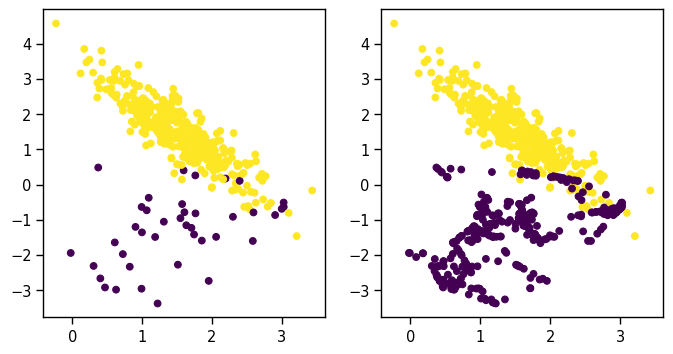

In [ ]:
plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.subplot(1,2,2)
plt.scatter(X_resampled[:,0], X_resampled[:,1], c=y_resampled)

- ADAYN(Adaptive Synthetic Sampling):
  - 소수 클래스 샘플의 학습 난이도를 계산하고, 난이도가 높은 샘플 근처에서 더 많은 샘플을 생성.
  - 클래스 간 경계가 복잡하거나 노이즈가 많은 경우 더 효과적.

In [ ]:
from imblearn.over_sampling import ADASYN, BorderlineSMOTE, SMOTE

smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)
print(Counter(y), Counter(y_smote))

bsmote = BorderlineSMOTE(random_state=42)
X_bsmote, y_bsmote = bsmote.fit_resample(X, y)
print(Counter(y), Counter(y_bsmote))

adasyn = ADASYN(random_state=42)
X_adasyn, y_adasyn = bsmote.fit_resample(X, y)
print(Counter(y), Counter(y_adasyn))

Counter({1: 360, 0: 40}) Counter({1: 360, 0: 360})
Counter({1: 360, 0: 40}) Counter({1: 360, 0: 360})
Counter({1: 360, 0: 40}) Counter({1: 360, 0: 360})


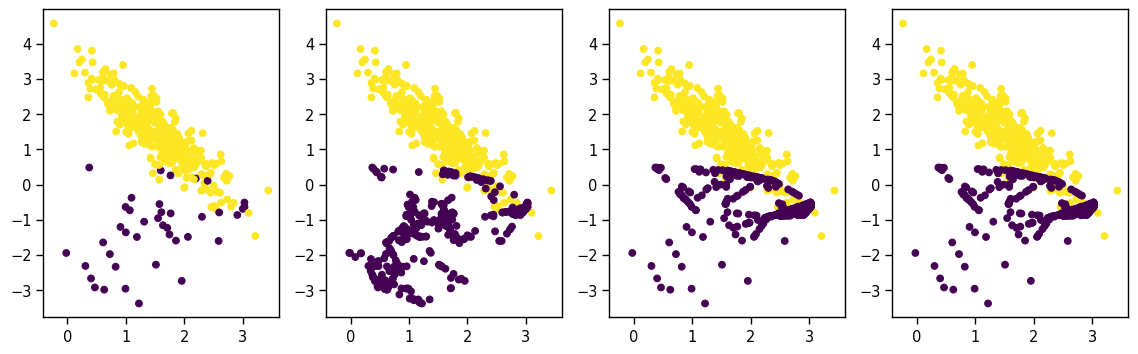

In [ ]:
plt.figure(figsize=(14,4))
plt.subplot(1,4,1)
plt.scatter(X[:,0], X[:,1], c=y)
plt.subplot(1,4,2)
plt.scatter(X_smote[:,0], X_smote[:,1], c=y_smote)
plt.subplot(1,4,3)
plt.scatter(X_bsmote[:,0], X_bsmote[:,1], c=y_bsmote)
plt.subplot(1,4,4)
plt.scatter(X_adasyn[:,0], X_adasyn[:,1], c=y_adasyn)